<h1 align='center' style='color:purple'>Credit Card Imbalanced Data Set</h1>

Credit Card Fraud Dataset, trying different algorithms, also try to run 2 consecutive tests to see if this can improve the model
Author: Donald Stierman

In [1]:
# Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling as pp
import seaborn as sns
import os

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import cohen_kappa_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot
import zipfile


In [2]:
colab = os.environ.get('COLAB_GPU', '10')
if (int(colab) == 0):
    from google.colab import drive
    drive.mount('/content/drive')
    #Path="drive/My Drive/Colab Notebooks/StockAnalysis"
    Path=""
    DataPath="/content"
    RootPath="/root"    
else:
    #Path="/c/DataScience/Repo/Imbalanced_data"
    Path="/DataScience/Repo/Imbalanced_data"
    DataPath=Path
    RootPath="/Users/iowahawk89"

In [3]:
with zipfile.ZipFile(DataPath+'/creditcard.zip', 'r') as zip_ref:
    zip_ref.extractall(Path)

In [4]:
# Load the Data Set
df = pd.read_csv('creditcard.csv')

In [5]:
# Check the data
print(df.head())

   Time_Series        V1        V2        V3        V4        V5        V6  \
0          0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388   
1          0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361   
2          1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499   
3          1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203   
4          2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921   

         V7        V8        V9  ...       V21       V22       V23       V24  \
0  0.239599  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928   
1 -0.078803  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846   
2  0.791461  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281   
3  0.237609  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575   
4  0.592941 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount 

In [6]:
# Check the datatypes of the Data set 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Time_Series  284807 non-null  float64
 1   V1           284807 non-null  float64
 2   V2           284807 non-null  float64
 3   V3           284807 non-null  float64
 4   V4           284807 non-null  float64
 5   V5           284807 non-null  float64
 6   V6           284807 non-null  float64
 7   V7           284807 non-null  float64
 8   V8           284807 non-null  float64
 9   V9           284807 non-null  float64
 10  V10          284807 non-null  float64
 11  V11          284807 non-null  float64
 12  V12          284807 non-null  float64
 13  V13          284807 non-null  float64
 14  V14          284807 non-null  float64
 15  V15          284807 non-null  float64
 16  V16          284807 non-null  float64
 17  V17          284807 non-null  float64
 18  V18          284807 non-

In [7]:
# Check the Uniqueness
df.nunique()

Time_Series    124592
V1             275663
V2             275662
V3             275663
V4             275662
V5             275662
V6             275662
V7             275662
V8             275661
V9             275662
V10            275659
V11            275662
V12            275662
V13            275663
V14            275662
V15            275661
V16            275661
V17            275662
V18            275662
V19            275661
V20            275661
V21            275660
V22            275661
V23            275659
V24            275662
V25            275661
V26            275661
V27            275659
V28            275653
Amount          32767
Class               2
dtype: int64

In [8]:
# Check for missing data
df.isnull().sum()

Time_Series    0
V1             0
V2             0
V3             0
V4             0
V5             0
V6             0
V7             0
V8             0
V9             0
V10            0
V11            0
V12            0
V13            0
V14            0
V15            0
V16            0
V17            0
V18            0
V19            0
V20            0
V21            0
V22            0
V23            0
V24            0
V25            0
V26            0
V27            0
V28            0
Amount         0
Class          0
dtype: int64

In [9]:
# Check the Statistics

df.describe(include ='all')

,Time_Series,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,-2.971792e-14,2.531226e-14,-1.923049e-14,1.093810e-14,-6.677660e-14,1.285053e-14,-5.204238e-14,1.023695e-14,2.237256e-15,...,-3.823399e-14,9.996013e-14,8.036320e-15,3.042869e-14,-8.644179e-14,-9.235807e-14,-5.269689e-14,9.542474e-14,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781942e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [10]:
# Check the Class Imbalance of the Data 

df['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

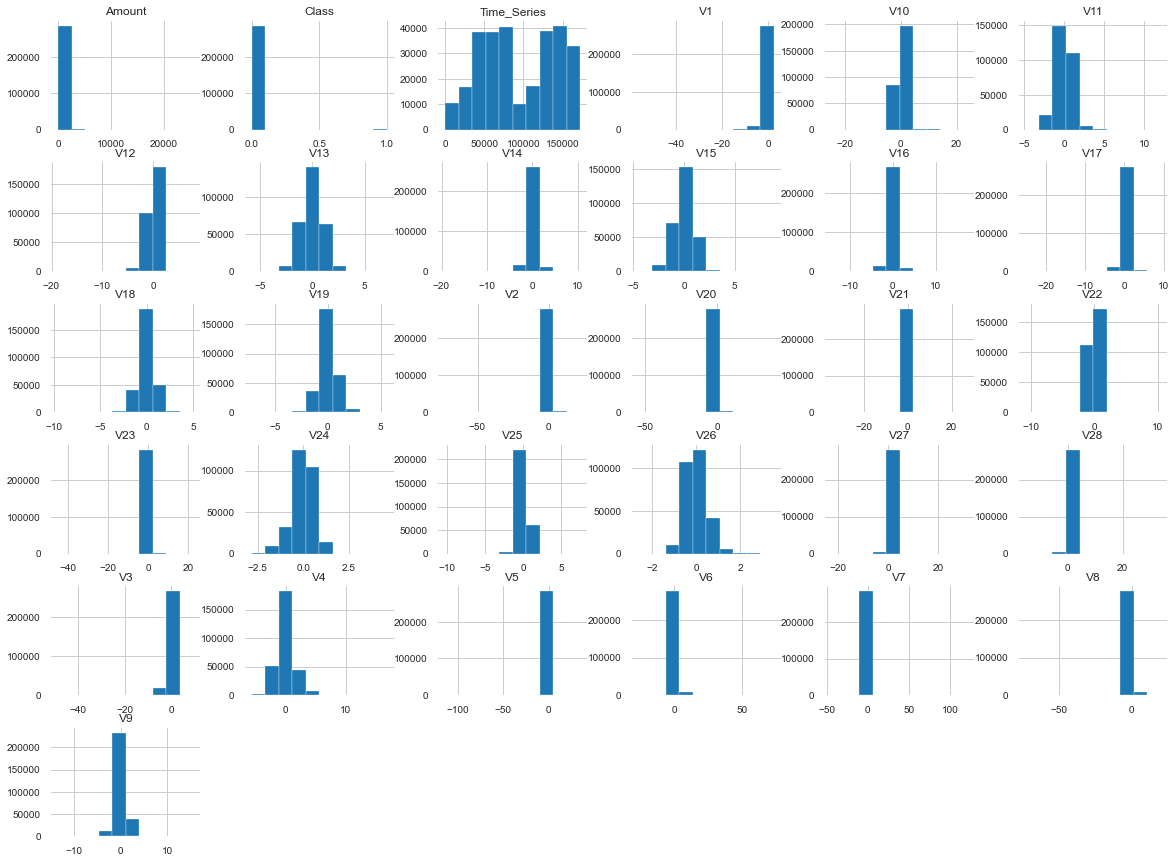

In [11]:
# Histograms of the features

df.hist(bins=10, figsize=(20,15))
plt.show()

In [12]:
# divide full data into features and label

X = df.loc[:, df.columns != 'Class']
y = df.loc[:, df.columns == 'Class']
# Split the Data into Train and Test 

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
print('X_train',X_train.shape) # X_train (199364, 30)
print('X_test',X_test.shape) # X_test (85443, 30)

class_names=[0,1] # name  of classes 1=fraudulent transaction

X_train (199364, 30)
X_test (85443, 30)


In [13]:
# find the number of minority (value=1) samples in our train set so we can down-sample our majority to it
yes = len(y_train[y_train['Class'] ==1])

# retrieve the indices of the minority and majority samples 
yes_ind = y_train[y_train['Class'] == 1].index
no_ind = y_train[y_train['Class'] == 0].index

# random sample the majority indices based on the amount of 
# minority samples
new_no_ind = np.random.choice(no_ind, yes, replace = False)

# merge the two indices together
undersample_ind = np.concatenate([new_no_ind, yes_ind])

# get undersampled dataframe from the merged indices of the train dataset
X_train = X_train.loc[undersample_ind]
y_train = y_train.loc[undersample_ind]

run Logistic Regression model first

In [14]:
lr = LogisticRegression()
#lr = LogisticRegression(solver='lbfgs')

lr.fit(X_train, y_train)

lr_Pred=lr.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, lr_Pred))

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\utils\validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


              precision    recall  f1-score   support

           0       1.00      0.96      0.98     85307
           1       0.04      0.93      0.07       136

    accuracy                           0.96     85443
   macro avg       0.52      0.94      0.52     85443
weighted avg       1.00      0.96      0.98     85443



In [15]:
def visualize(Actual, Pred, Algo):
    #Confusion Matrix
    cnf_matrix=metrics.confusion_matrix(Actual, Pred) #

    #Visualize confusion matrix using heat map

    fig, ax = plt.subplots()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names)
    plt.yticks(tick_marks, class_names)

    # create heatmap
    sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    ax.xaxis.set_label_position("top")
    plt.tight_layout()
    plt.title('Confusion matrix: '+Algo, y=1.1) 
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

In [16]:
def display_metrics(model_name, train_features, test_features, train_label, test_label, pred):
    print(model_name.score(test_features, test_label)) 
    print(pd.Series(model_name.feature_importances_, index=train_features.columns[:]).nlargest(10).plot(kind='barh')) 
    print("Accuracy score (training): {0:.3f}".format(model_name.score(train_features, train_label))) 
    print("Accuracy score (validation): {0:.3f}".format(model_name.score(test_features, test_label))) 
    print("Confusion Matrix:")
    tn, fp, fn, tp = confusion_matrix(test_label, pred).ravel()
    total = tn+ fp+ fn+ tp 
    print("false positive pct:",(fp/total)*100) 
    print("tn", " fp", " fn", " tp") 
    print(tn, fp, fn, tp) 
    print(confusion_matrix(test_label, pred)) 
    print("Classification Report") 
    print(classification_report(test_label, pred))
    return tn, fp, fn, tp

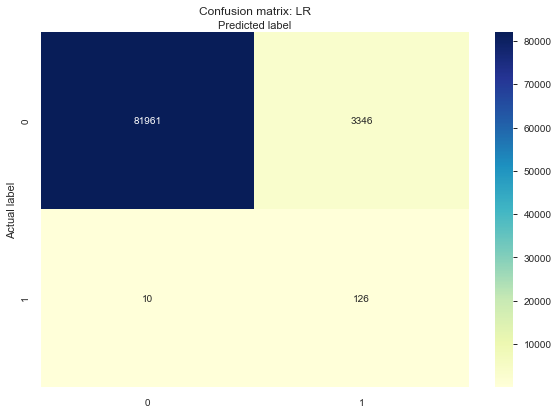

In [17]:
visualize(y_test, lr_Pred, 'LR')

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.974


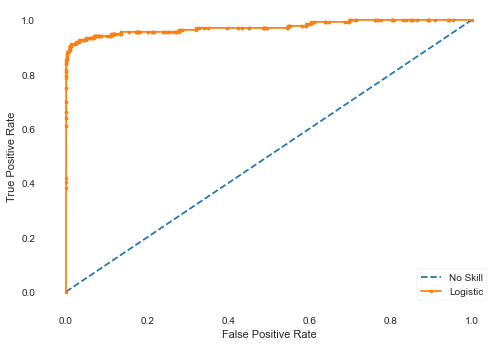

In [18]:
# useful for balanced data, included here for an example to use later

ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, lr_probs)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
# plot the roc curve for the model
pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.070 auc=0.481


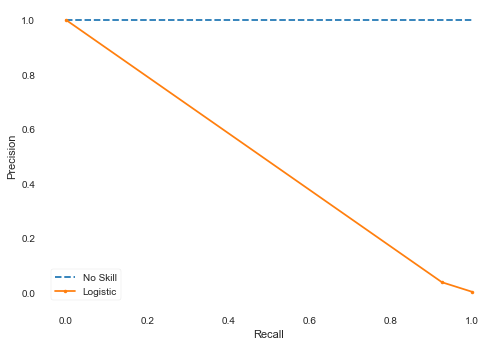

In [19]:
# useful for unbalanced data

lr_precision, lr_recall, _ = precision_recall_curve(y_test, lr_Pred)
lr_f1, lr_auc = f1_score(y_test, lr_Pred), auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(y_test[y_test==1]) / len(y_test)
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Next try the Random Forest model

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85307
           1       0.05      0.93      0.10       136

    accuracy                           0.97     85443
   macro avg       0.53      0.95      0.54     85443
weighted avg       1.00      0.97      0.98     85443



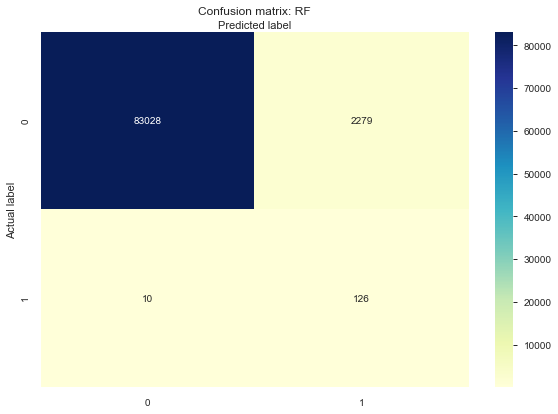

In [20]:
rf = RandomForestClassifier(n_estimators = 1000)

rf.fit(X_train, y_train)

rf_Pred=rf.predict(X_test)

#print(metrics.accuracy_score(y_test, y_pred))
print(classification_report(y_test, rf_Pred))
visualize(y_test, rf_Pred, 'RF')

So far, logistic regression has better prediction capability, the RandomForestClassifier test has a lot more mistakes in the False Positive category, and only a few less mistakes in the False Negative category.

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9864236976697915
AxesSubplot(0.125,0.125;0.775x0.755)
Accuracy score (training): 0.934
Accuracy score (validation): 0.986
Confusion Matrix:
false positive pct: 1.3459265241154923
tn  fp  fn  tp
84157 1150 10 126
[[84157  1150]
 [   10   126]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85307
           1       0.10      0.93      0.18       136

    accuracy                           0.99     85443
   macro avg       0.55      0.96      0.59     85443
weighted avg       1.00      0.99      0.99     85443



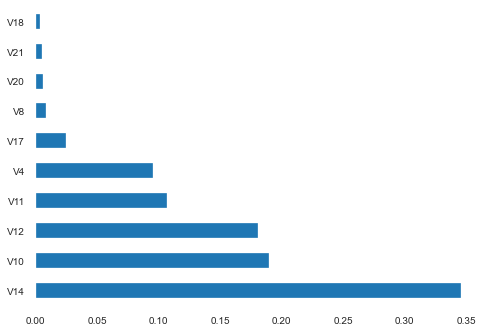

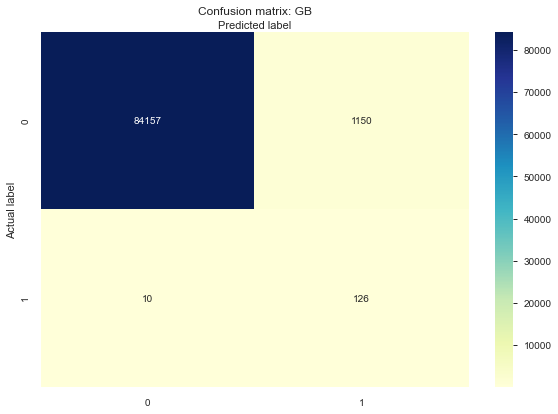

In [21]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=10, 
                                    max_depth=3, random_state=0, subsample = 0.5, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly
gb_clf.fit( X_train, y_train, sample_weight=np.where(y_train == 1,0.5,1.0) ) #  fn = 12 and fp = 1057
# no weights gives worse false positive counts
#gb_clf.fit( X_train, y_train) # fn = 8 and fp = 2639

#use model to predict validation dataset
predictions = gb_clf.predict(X_test)

tn, fp, fn, tp = display_metrics(gb_clf, X_train, X_test, y_train, y_test, predictions)
visualize(y_test, predictions, 'GB')

After tweaking the parameters, i get a better result from GradientBoostingClassifier. Changing the weights has a very large influence on the number of errors (FN and FP). Decreasing the weight of a true value vs a false value will decrease the FN, doing the opposite will decrease the FP. For example:  the sample_weight=np.where(y_train == 1,0.37,1.0) gives 13 FN and 795 FP. sample_weight=np.where(y_train == 1,0.1,1.0) gives 17 FN and 217 FP

my next idea is to run 2 consecutive models. 1st model should have low false negatives to catch (almost) all the actual positives, even if the number of false positives is high. Then only take these records with a predicted 1 value (should only be a few thousand), as the input for the next model. 2nd test should have low false positives to weed out the actual negatives.
Can also try the inverse, but think that option will have less chance of success.

1st step

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.8381611132567911
AxesSubplot(0.125,0.125;0.775x0.755)
Accuracy score (training): 0.944
Accuracy score (validation): 0.838
Confusion Matrix:
false positive pct: 16.179207190758753
tn  fp  fn  tp
71483 13824 4 132
[[71483 13824]
 [    4   132]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.84      0.91     85307
           1       0.01      0.97      0.02       136

    accuracy                           0.84     85443
   macro avg       0.50      0.90      0.47     85443
weighted avg       1.00      0.84      0.91     85443



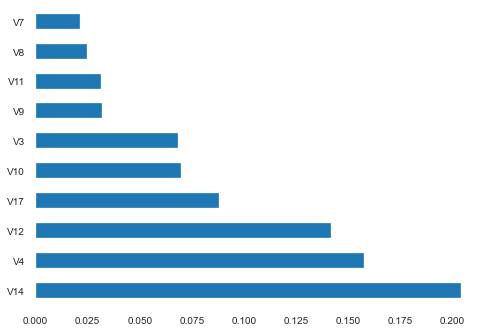

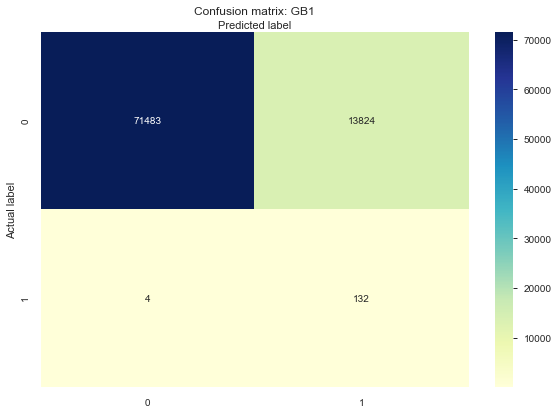

In [22]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=0, subsample = 1.0, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important, also more rare
gb_clf.fit( X_train, y_train, sample_weight=np.where(y_train == 1,5.0,1.0) )

#use model to predict validation dataset
predictions = gb_clf.predict(X_test) 

tn1, fp1, fn1, tp1 = display_metrics(gb_clf, X_train, X_test, y_train, y_test, predictions)
visualize(y_test, predictions, 'GB1')


2nd step takes all the Predicted Positives (the misclassified FP from upper right (~ 14000) plus the TP (since we won't use the actual value until the validation step)) and reprocesses these using a different model. The other 2 squares (Predicted 0's) are not included in the 2nd model, since we already have a low False negative result, so the initial predicted 0s don't change. Will need to add those back into the final results at the end.

Add 1st model prediction column to X_test

In [23]:
X_test['Prediction'] = predictions

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


select rows with prediction of 1

In [24]:
yes_ind = X_test[X_test['Prediction'] == 1].index

Create 2nd train dataset from 1st dataset where the prediction was 1

In [25]:
X2_test = X_test.loc[yes_ind]
y2_test = y_test.loc[yes_ind]
X2_test = X2_test.drop(['Prediction'], axis=1)

run the 2nd model

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1448: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  sample_weight = column_or_1d(sample_weight, warn=True)
C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\ensemble\_gb.py:1454: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.9762109486959014
AxesSubplot(0.125,0.125;0.775x0.755)
Accuracy score (training): 0.923
Accuracy score (validation): 0.976
Confusion Matrix:
false positive pct: 2.292920607623961
tn  fp  fn  tp
13504 320 12 120
[[13504   320]
 [   12   120]]
Classification Report
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     13824
           1       0.27      0.91      0.42       132

    accuracy                           0.98     13956
   macro avg       0.64      0.94      0.70     13956
weighted avg       0.99      0.98      0.98     13956

2 Step Final Confusion Matrix:
84987 320
16 120


Text(0.5, 352.48, 'Predicted label')

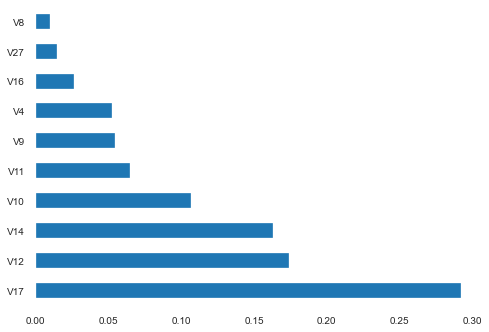

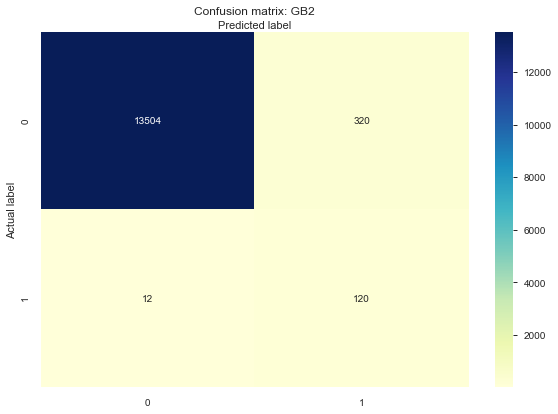

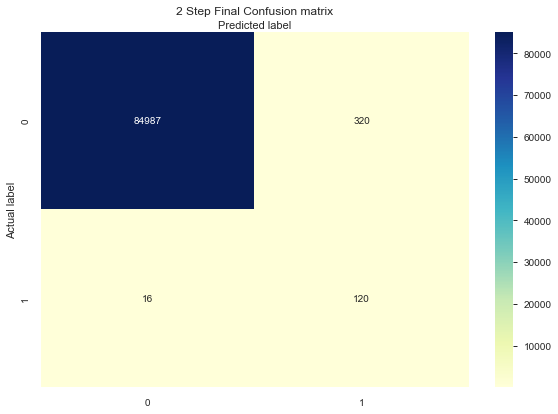

In [26]:
#setup model parameters, change some of the defaults based on benchmarking
gb_clf = GradientBoostingClassifier(n_estimators=20, learning_rate=0.1, max_features=5, 
                                    max_depth=3, random_state=0, subsample = 1.0, criterion='mse', 
                                    min_samples_split = 10, min_samples_leaf = 10)

#default fit model
#gb_clf.fit(X_train, y_train)

#since a false negative is much more likely than a false positive, we should weight them accordingly. 
#IE Finding a true one is more important
# note that the weights in the 2nd model are the inverse of the weights in the 1st model
gb_clf.fit( X_train, y_train, sample_weight=np.where(y_train == 1,0.1,1.0) )

#use model to predict validation dataset
predictions = gb_clf.predict(X2_test) 

tn, fp, fn, tp = display_metrics(gb_clf, X_train, X2_test, y_train, y2_test, predictions)

visualize(y2_test, predictions, 'GB2')

print("2 Step Final Confusion Matrix:")
print(tn+tn1, fp) 
print(fn+fn1, tp) 

fig, ax = plt.subplots() 
tick_marks = np.arange(len(class_names)) 
plt.xticks(tick_marks, class_names) 
plt.yticks(tick_marks, class_names)

#create heatmap with combined data from both models
sns.heatmap(pd.DataFrame([[tn+tn1,fp],[fn+fn1,tp]]), annot=True, cmap="YlGnBu" ,fmt='g') 
ax.xaxis.set_label_position("top") 
plt.tight_layout() 
plt.title('2 Step Final Confusion matrix', y=1.1) 
plt.ylabel('Actual label') 
plt.xlabel('Predicted label')

The 2 step modelling process improves the overall model prediction by a large amount (148 incorrect predictions). I don't think we could get this high of precision and recall together with a single model. The best I could do with a single model was 1283 incorrect predictions.

Next will try a NN

In [27]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
#from keras.callbacks import ModelCheckpoint, TensorBoard
from keras import regularizers

Using TensorFlow backend.


In [28]:
# prepare data for model
X_test.drop(X_test.columns[[-1,]], axis=1, inplace=True)
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [29]:
def create_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.25),
        Dense(20, kernel_initializer='uniform', activation='relu'),
        Dense(24, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [30]:
def create_simple_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dense(1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

In [31]:
def create_complex_dnn():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=16, kernel_initializer='uniform', input_dim=30, activation='relu'),
        Dense(units=18, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=28, kernel_initializer='uniform', activation='relu'),
        Dropout(0.10),
        Dense(units=20, kernel_initializer='uniform', activation='relu'),
        Dense(units=24, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_2 (Dense)              (None, 18)                306       
_________________________________________________________________
dropout_1 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                380       
_________________________________________________________________
dense_4 (Dense)              (None, 24)                504       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 25        
Total params: 1,711
Trainable params: 1,711
Non-trainable params: 0
____________________________________________________

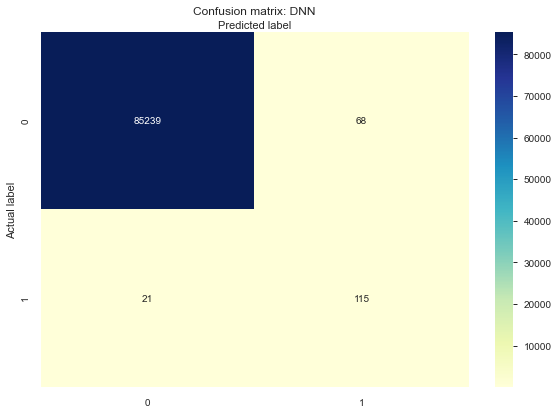

In [32]:
clf = create_dnn()
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

visualize(y_test, yhat_classes, 'DNN')

Results from Deep NN are better than 1 step/model examples, but not as good as the 2 step/model process. As more data is added or processed through this DNN, the results should improve, maybe eventually beating the 2 step model. However, it seems that increasing the number of epochs will weight the model to higher false negatives, similar to using sample weights for the GBM model:

**sample_weight=np.where(y_train == 1,0.1,1.0)**

 **giving a 1 in the training data 10 times the weight or inflence of a 0**

For now, we will keep the number of epochs at 5.
Weighting has the same effect on this DNN as it had on the GBM. Best all around result with 

sample_weight=np.where(y_train == 1,0.1,1.0).flatten()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_7 (Dense)              (None, 18)                306       
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 19        
Total params: 821
Trainable params: 821
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
712/712 [==============================] - 0s 261us/step - loss: 0.3645 - accuracy: 0.5379
Epoch 2/5
712/712 [==============================] - 0s 106us/step - loss: 0.2283 - accuracy: 0.8006
Epoch 3/5
712/712 [==============================] - 0s 85us/step - loss: 0.0773 - accuracy: 0.8666
Epoch 4/5
712/712 [==============================] - 0s 86us/step - loss: 0.0548 - a

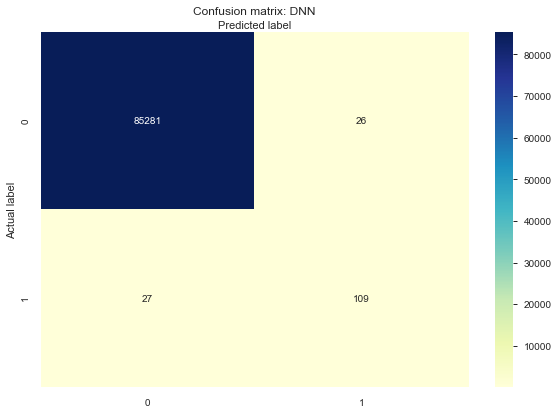

In [33]:
clf = create_simple_dnn()
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

visualize(y_test, yhat_classes, 'DNN')

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                496       
_________________________________________________________________
dense_10 (Dense)             (None, 18)                306       
_________________________________________________________________
dropout_2 (Dropout)          (None, 18)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 30)                570       
_________________________________________________________________
dense_12 (Dense)             (None, 28)                868       
_________________________________________________________________
dropout_3 (Dropout)          (None, 28)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 30)               

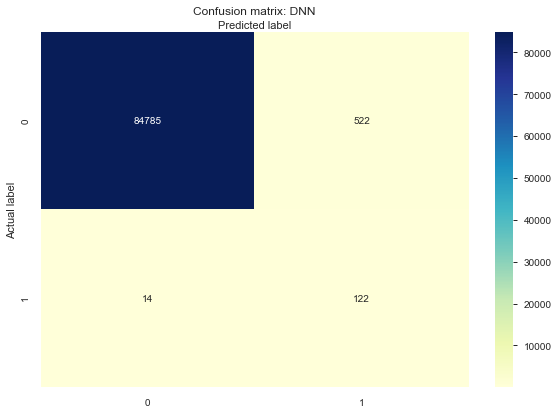

In [34]:
clf = create_complex_dnn()
clf.summary()
clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# create/fit model on the training dataset
clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,0.1,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=128)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=128)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

visualize(y_test, yhat_classes, 'DNN')

In [35]:
def create_autoencoder():
    # input_dim must equal number of features in X_train and X_test dataset
    clf1 = Sequential([
        Dense(units=14, kernel_initializer='uniform', input_dim=30, activation='tanh', activity_regularizer=regularizers.l1(10e-5)),
        Dense(units=7, kernel_initializer='uniform', activation='relu'),
        Dense(units=7, kernel_initializer='uniform', activation='tanh'),
        Dense(units=30, kernel_initializer='uniform', activation='relu'),
        Dense(units=1, kernel_initializer='uniform', activation='sigmoid')
    ])
    return clf1
a='''
input_layer = Input(shape=(30, ))
encoder = Dense(14, activation="tanh", activity_regularizer=regularizers.l1(10e-5))(input_layer)
encoder = Dense(7, activation="relu")(encoder)
decoder = Dense(7, activation='tanh')(encoder)
decoder = Dense(30, activation='relu')(decoder)
autoencoder = Model(inputs=input_layer, outputs=decoder)
'''

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 14)                434       
_________________________________________________________________
dense_19 (Dense)             (None, 7)                 105       
_________________________________________________________________
dense_20 (Dense)             (None, 7)                 56        
_________________________________________________________________
dense_21 (Dense)             (None, 30)                240       
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 31        
Total params: 866
Trainable params: 866
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
712/712 [==============================] - 0s 287us/step - loss: 0.2536 - accuracy: 0.5042
Epoch 2/100
712/712

C:\Users\iowahawk89\miniconda3\envs\ds_tensorflow\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85307
           1       0.00      0.00      0.00       136

    accuracy                           1.00     85443
   macro avg       0.50      0.50      0.50     85443
weighted avg       1.00      1.00      1.00     85443



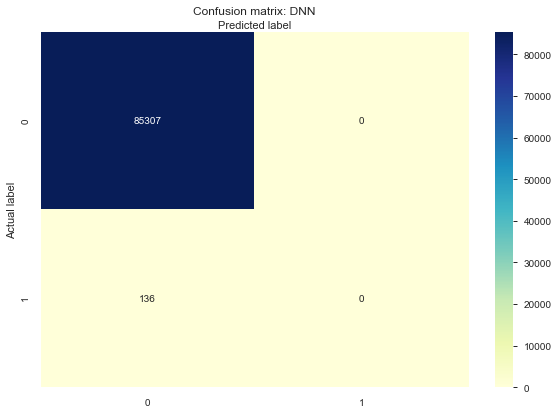

In [36]:
clf = create_autoencoder()
clf.summary()
clf.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])
#clf.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# create/fit model on the training dataset
clf.fit(X_train, y_train, batch_size=32, epochs=100, shuffle=True)#, validation_data=(X_test, X_test))
#clf.fit(X_train, y_train, batch_size=15, epochs=5, sample_weight=np.where(y_train == 1,5.0,1.0).flatten())
#clf.fit(X_train, y_train, batch_size=15, epochs=5)

# check model metrics
score = clf.evaluate(X_train, y_train, batch_size=32)
print('\nAnd the Train Score is ', score[1] * 100, '%')
score = clf.evaluate(X_test, y_test, batch_size=32)
print('\nAnd the Test Score is ', score[1] * 100, '%')
# predict probabilities for test set
yhat_probs = clf.predict(X_test, verbose=0)
# predict crisp classes for test set
yhat_classes = clf.predict_classes(X_test, verbose=0)
# reduce to 1d array
yhat_probs = yhat_probs[:, 0]
yhat_classes = yhat_classes[:, 0]
print("Classification Report (DNN)") 
print(classification_report(y_test, yhat_classes))

visualize(y_test, yhat_classes, 'DNN')